# DB-Scan

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

## ```Cyclist``` Dataset

In [2]:
cyclists_df = pd.read_csv('../dataset/cyclists_outlier.csv')

In [ ]:
# Specify the columns to keep
columns_to_keep = ["avg_relative_position", "career_level", "relative_position_std"] 
# new dataset with only the specified columns

# drop the unnecessary columns for the clustering and keep only the numerical columns
numerical_races_df = cyclists_df[columns_to_keep]
numerical_races_df

,avg_relative_position,career_level,relative_position_std
0,0.456286,0.899462,0.243635
1,0.630686,-0.572894,0.205735
2,0.557360,-0.123706,0.219011
3,0.464642,-0.502688,0.238795
4,0.589817,-0.152291,0.238517
...,...,...,...
4140,0.510309,-0.496200,0.340690
4141,0.637519,-0.593160,0.215697
4142,0.697735,-0.600964,0.150866
4143,0.413682,-0.303189,0.238513


Feature normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(numerical_races_df)
x_scaled.shape

(4145, 3)

In [5]:
for i, column in enumerate(columns_to_keep):
    print(f"{column}: min = {x_scaled[:, i].min()}, max = {x_scaled[:, i].max()}")

avg_relative_position: min = 0.0, max = 1.0
career_level: min = 0.0, max = 0.9999999999999999
relative_position_std: min = 0.0, max = 1.0


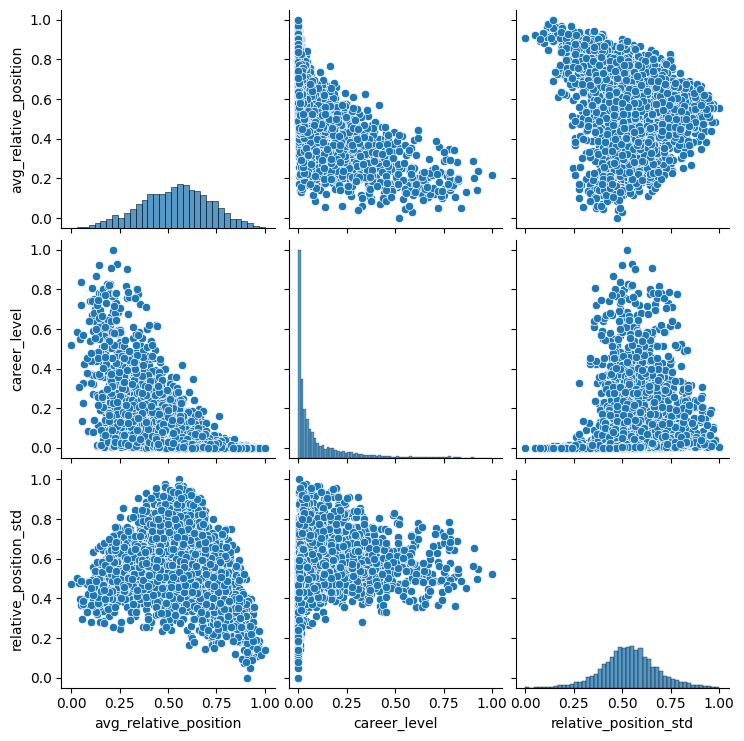

In [6]:
import seaborn as sns

# Create a DataFrame from x_scaled
x_scaled_df = pd.DataFrame(x_scaled, columns=columns_to_keep)
sns.pairplot(x_scaled_df)
plt.show()

In [7]:
dist = pdist(x_scaled, 'euclidean') # pair-wise distances
dist = squareform(dist) # distance matrix

In [8]:
k = 5
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

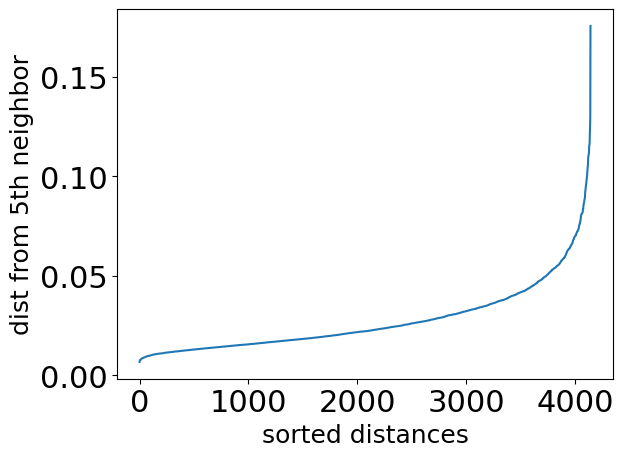

In [9]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

The elbow value is at index: 4078


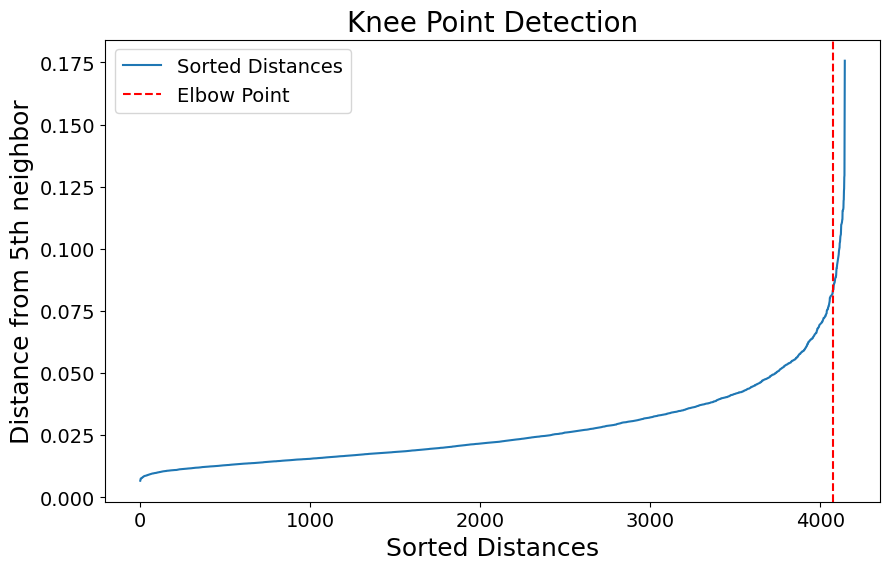

In [10]:
sorted_distances = np.sort(kth_distances)
kneedle = KneeLocator(
    np.arange(1, len(sorted_distances) + 1),
    sorted_distances,
    curve='convex',
    direction='increasing'
)

# Extract elbow value
elbow_value = kneedle.elbow
print(f'The elbow value is at index: {elbow_value}')

# Plot kth distances with the elbow point
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_distances)), sorted_distances, label="Sorted Distances")
plt.axvline(x=elbow_value - 1, color='r', linestyle='--', label="Elbow Point")
plt.ylabel(f'Distance from {k}th neighbor', fontsize=18)
plt.xlabel('Sorted Distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Knee Point Detection', fontsize=20)
plt.legend(fontsize=14)
plt.show()

In [11]:
min_samples = [5, 10, 15, 20, 50, 80, 100, 120, 150, 200]
epsilon_candidates = np.linspace(0.01, 2, 100)

In [12]:
results = []
for eps in epsilon_candidates:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(x_scaled)
        n_clusters = len(np.unique(dbscan.labels_))
        if n_clusters == 1:
            silhouette = -1
            DBscore = max

        else:
            silhouette = silhouette_score(x_scaled, dbscan.labels_)
            DBscore = davies_bouldin_score(x_scaled, dbscan.labels_)
        results.append({'eps': eps, 'min_samples': min_sample, 'n_clusters': n_clusters, 'silhouette': silhouette, 'DBscore': DBscore})
        

### Best Result

In [13]:
results_df = pd.DataFrame(results).sort_values(by=['silhouette'], ascending=False)
results_df.head(10)

,eps,min_samples,n_clusters,silhouette,DBscore
159,0.311515,200,2,0.637264,0.241227
116,0.231111,100,2,0.637264,0.241227
115,0.231111,80,2,0.637264,0.241227
94,0.190909,50,2,0.637264,0.241227
126,0.251212,100,2,0.637264,0.241227
72,0.150707,15,2,0.637264,0.241227
73,0.150707,20,2,0.637264,0.241227
105,0.211010,80,2,0.637264,0.241227
83,0.170808,20,2,0.637264,0.241227
127,0.251212,120,2,0.637264,0.241227


In [14]:
from sklearn.decomposition import PCA

eps = results_df.iloc[0]['eps']
min_samples = int(results_df.iloc[0]['min_samples'])

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(x_scaled)

DBSCAN(eps=np.float64(0.3115151515151515), min_samples=200)

In [15]:
unique_labels, counts = np.unique(dbscan.labels_, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} samples")

Cluster -1: 1 samples
Cluster 0: 4144 samples


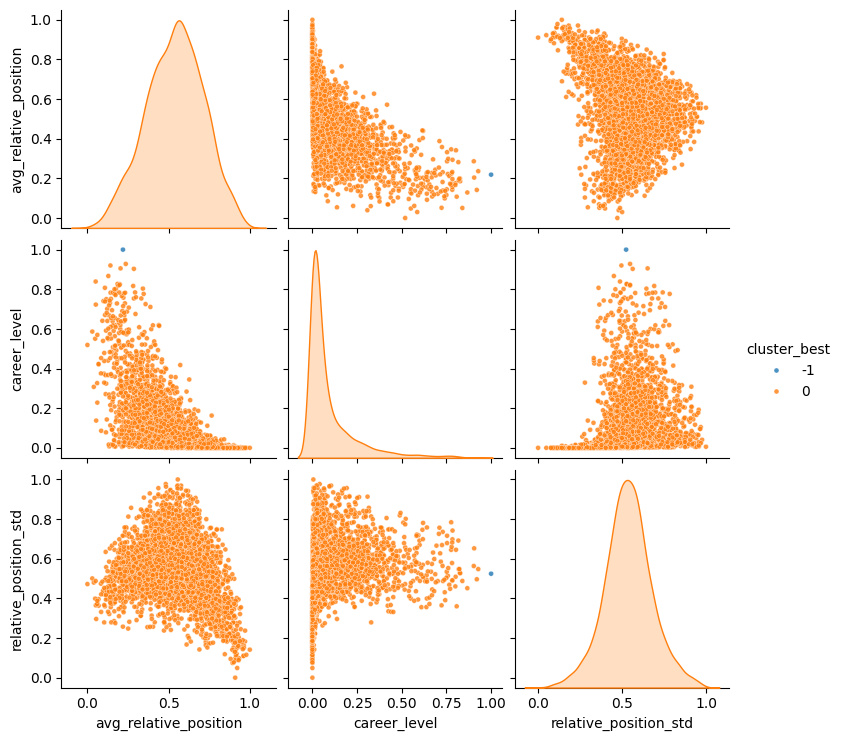

In [16]:
# Create a DataFrame with the scaled features and cluster labels
x_scaled_df['cluster_best'] = dbscan.labels_

# Plot pairplot with seaborn
sns.pairplot(x_scaled_df, hue='cluster_best', plot_kws={'s': 13, 'alpha': 0.8}, palette="tab10")
plt.show()

### Best Result With K>1

In [ ]:
results_df = pd.DataFrame(results).sort_values(by=['n_clusters', 'silhouette'], ascending=[False, False])
results_df.head(20)

,eps,min_samples,n_clusters,silhouette,DBscore
0,0.010000,5,58,-0.443554,1.350488
10,0.030101,5,23,-0.245372,1.881429
11,0.030101,10,13,-0.236194,2.99144
20,0.050202,5,9,0.196834,1.607644
13,0.030101,20,4,-0.115897,1.300767
30,0.070303,5,3,0.483414,1.436418
31,0.070303,10,3,0.462983,1.204626
32,0.070303,15,3,0.428079,4.300651
40,0.090404,5,3,0.425893,1.336336
12,0.030101,15,3,0.074688,1.282512


In [24]:
from sklearn.decomposition import PCA

eps = 0.07#results_df.iloc[0]['eps']
min_samples = 10#int(results_df.iloc[0]['min_samples'])

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(x_scaled)

DBSCAN(eps=0.07, min_samples=10)

In [25]:
unique_labels, counts = np.unique(dbscan.labels_, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} samples")

Cluster -1: 117 samples
Cluster 0: 4010 samples
Cluster 1: 18 samples


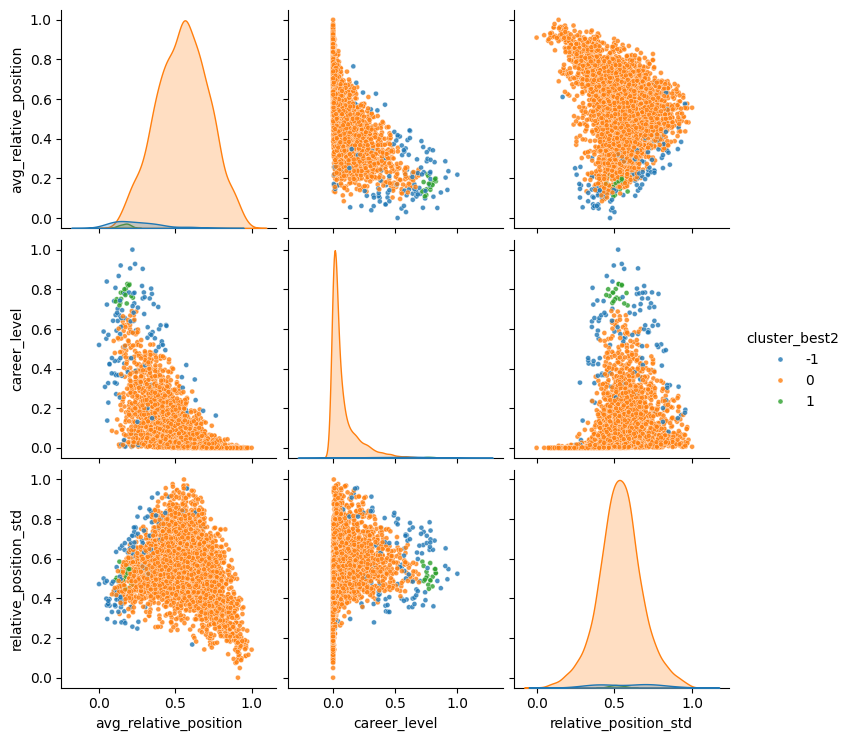

In [27]:
# Create a DataFrame with the scaled features and cluster labels
x_scaled_df['cluster_best2'] = dbscan.labels_

# Plot pairplot with seaborn
sns.pairplot(x_scaled_df.drop(columns="cluster_best"), hue='cluster_best2', plot_kws={'s': 13, 'alpha': 0.8}, palette="tab10")
plt.show()

Count how many cyclists ends up in 1 class and how much in 0 class observing best cyclists (According to higher levek, ie the higher career level the best the cyclsist)

In [45]:
x_scaled_df.sort_values(by='career_level', ascending=False).head(42)['cluster_best2'].value_counts()

cluster_best2
-1    24
 1    18
Name: count, dtype: int64

As if it's possible to observe this DBSCAN run puts in class 1 only best cyclists that it not consider as outliers

---

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

## ```Races``` Dataset

In [2]:
races_df = pd.read_csv('../dataset/races_outlier.csv')

In [5]:
# Specify the columns to keep
columns_to_keep = ["climb_total", "length"]
# new dataset with only the specified columns

# drop the unnecessary columns for the clustering and keep only the numerical columns
numerical_races_df = races_df[columns_to_keep]
numerical_races_df

,climb_total,length
0,3.300,2.565
1,3.500,2.518
2,3.495,2.514
3,3.558,2.580
4,3.320,2.487
...,...,...
2520,4.120,1.812
2521,3.359,1.900
2522,3.741,1.534
2523,3.675,1.714


Feature normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(numerical_races_df)
x_scaled.shape

(2525, 2)

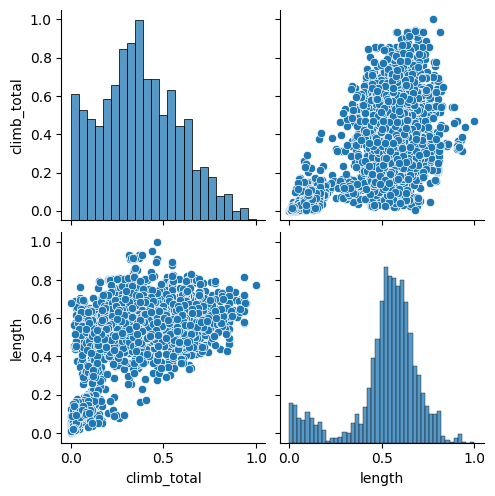

In [8]:
import seaborn as sns

# Create a DataFrame from x_scaled
x_scaled_df = pd.DataFrame(x_scaled, columns=columns_to_keep)
sns.pairplot(x_scaled_df)
plt.show()

In [9]:
dist = pdist(x_scaled, 'euclidean') # pair-wise distances
dist = squareform(dist) # distance matrix

In [10]:
k = 5
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

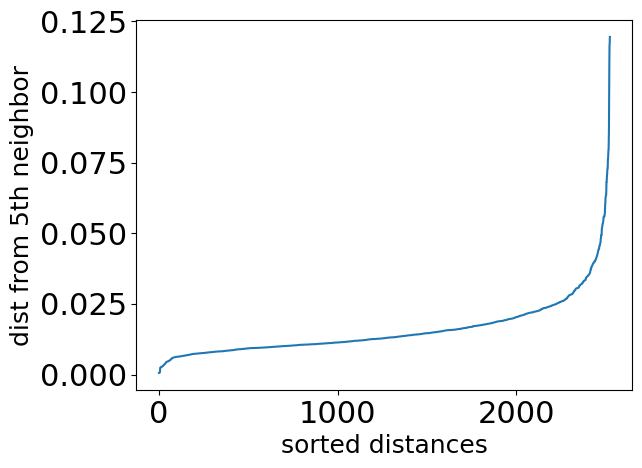

In [11]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

The elbow value is at index: 2494


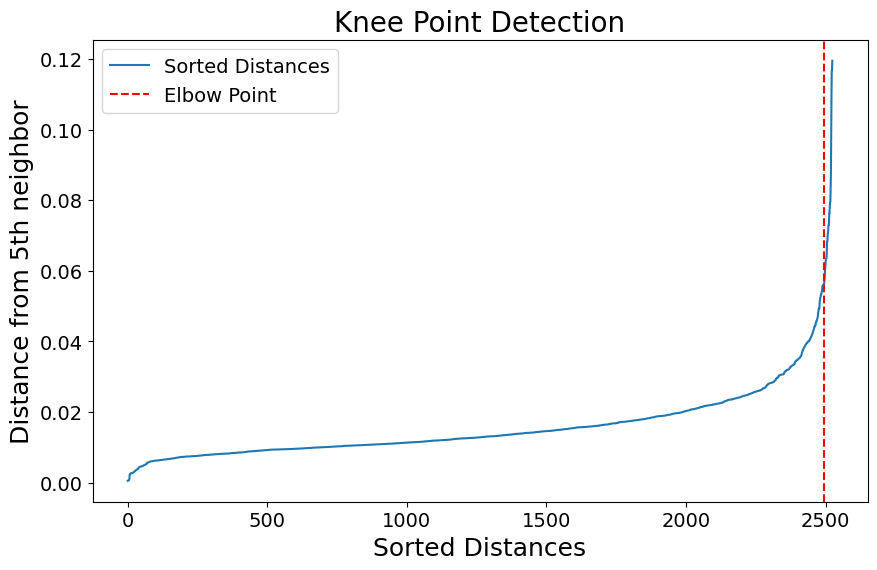

In [12]:
sorted_distances = np.sort(kth_distances)
kneedle = KneeLocator(
    np.arange(1, len(sorted_distances) + 1),
    sorted_distances,
    curve='convex',
    direction='increasing'
)

# Extract elbow value
elbow_value = kneedle.elbow
print(f'The elbow value is at index: {elbow_value}')

# Plot kth distances with the elbow point
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_distances)), sorted_distances, label="Sorted Distances")
plt.axvline(x=elbow_value - 1, color='r', linestyle='--', label="Elbow Point")
plt.ylabel(f'Distance from {k}th neighbor', fontsize=18)
plt.xlabel('Sorted Distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Knee Point Detection', fontsize=20)
plt.legend(fontsize=14)
plt.show()

In [13]:
min_samples = [5, 10, 15, 20, 50, 80, 100, 120, 150, 200]
epsilon_candidates = np.linspace(0.01, 2, 100)

In [14]:
results = []
for eps in epsilon_candidates:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(x_scaled)
        n_clusters = len(np.unique(dbscan.labels_))
        if n_clusters == 1:
            silhouette = -1
            DBscore = max

        else:
            silhouette = silhouette_score(x_scaled, dbscan.labels_)
            DBscore = davies_bouldin_score(x_scaled, dbscan.labels_)
        results.append({'eps': eps, 'min_samples': min_sample, 'n_clusters': n_clusters, 'silhouette': silhouette, 'DBscore': DBscore})
        

### Best Result

Given that best result based only on silhouette returns one big cluster and some outlier, we decided to directly investigate for more interesting results (k>1)

In [44]:
results_df = pd.DataFrame(results).sort_values(by=['n_clusters', 'silhouette'], ascending=[False, False])
results_df.head(10)

,eps,min_samples,n_clusters,silhouette,DBscore
0,0.010000,5,82,-0.307217,2.258116
1,0.010000,10,22,-0.521524,8.297173
12,0.030101,15,9,-0.088378,2.478504
11,0.030101,10,8,-0.024395,2.745243
10,0.030101,5,7,0.088700,1.931316
13,0.030101,20,5,0.029468,3.764506
58,0.110505,150,3,0.429868,3.168965
68,0.130606,150,3,0.429685,1.894387
79,0.150707,200,3,0.427633,0.921164
69,0.130606,200,3,0.426346,1.868805


In [54]:
from sklearn.decomposition import PCA

eps = 0.150707 #results_df.iloc[0]['eps']
min_samples = 200 #int(results_df.iloc[0]['min_samples'])

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(x_scaled)

DBSCAN(eps=0.150707, min_samples=200)

In [55]:
unique_labels, counts = np.unique(dbscan.labels_, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} samples")

Cluster -1: 14 samples
Cluster 0: 2242 samples
Cluster 1: 269 samples


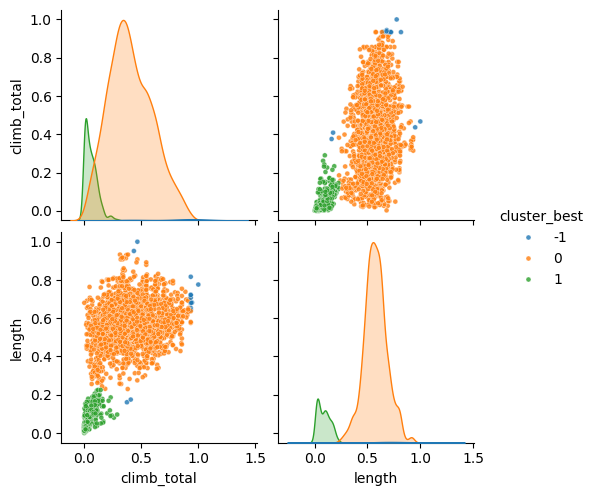

In [56]:
# Create a DataFrame with the scaled features and cluster labels
x_scaled_df['cluster_best'] = dbscan.labels_

# Plot pairplot with seaborn
sns.pairplot(x_scaled_df, hue='cluster_best', plot_kws={'s': 13, 'alpha': 0.8}, palette="tab10")
plt.show()

This result shows that races with lower length an lower climb total are clusterized toghether while races with higher lentgh and higher climb toatl forms a big dense cluster